In [1]:
import h5py
import scanpy as sc
import scipy
import mira
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

/media/RAIDArray/Nick/miniconda3/envs/mira-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# vdj analysis

In [3]:
adata = sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/scRNA_220830/human_B_cell_scRNA_seq_220831/outs/human_B_cell_scRNA_seq_230327.umap.leiden_clusters.h5ad")

In [4]:
filter_leiden = ~adata.obs['leiden'].isin(["7", "9"])
filter_class = ~adata.obs['Classification'].isin(["Doublet", "Negative"])
adata.obs['leiden_filtered_cells'] = filter_leiden & filter_class
adata = adata[adata.obs['leiden_filtered_cells']].copy()

In [5]:
adata_day6_index = adata.obs['Classification'].isin(['day6'])
adata_day6 = adata[adata_day6_index]

In [6]:
df_vdj=pd.read_csv('/media/RAIDArray/Nick/projects/human_Bcell_GRN/donor1_upmc_scRNAseq/tables/vdj/all_contig_annotations.csv',sep=',',header=0)

In [7]:
df_vdj.columns

Index(['barcode', 'is_cell', 'contig_id', 'high_confidence', 'length', 'chain',
       'v_gene', 'd_gene', 'j_gene', 'c_gene', 'full_length', 'productive',
       'fwr1', 'fwr1_nt', 'cdr1', 'cdr1_nt', 'fwr2', 'fwr2_nt', 'cdr2',
       'cdr2_nt', 'fwr3', 'fwr3_nt', 'cdr3', 'cdr3_nt', 'fwr4', 'fwr4_nt',
       'reads', 'umis', 'raw_clonotype_id', 'raw_consensus_id',
       'exact_subclonotype_id'],
      dtype='object')

In [8]:
df_vdj['c_gene'].unique()

array(['IGLC2', 'IGHM', 'IGKC', nan, 'IGHG3', 'IGLC1', 'IGHA1', 'IGHD',
       'IGLC3', 'IGHG1', 'IGHG4', 'IGHG2', 'IGHA2', 'IGLC7', 'IGHE'],
      dtype=object)

In [9]:
df_vdj['umis']

0         108
1         109
2         192
3          66
4          75
         ... 
83586    7435
83587    8402
83588      12
83589       9
83590      13
Name: umis, Length: 83591, dtype: int64

In [10]:
dict_barcode_vdj= df_vdj[~pd.isnull(df_vdj['raw_clonotype_id'])].set_index('barcode').to_dict()['raw_clonotype_id']

In [11]:
adata.obs['clonotype_id']=[dict_barcode_vdj[i] if i in dict_barcode_vdj else 'None' for i in adata.obs.index ]

In [12]:
adata.obs['clonotype_id'].value_counts()

clonotype_id
None              5512
clonotype1          10
clonotype2           7
clonotype8           6
clonotype3           5
                  ... 
clonotype6565        1
clonotype11912       1
clonotype4501        1
clonotype585         1
clonotype7557        1
Name: count, Length: 12865, dtype: int64

In [13]:
dict_barcode_isotype= df_vdj[~pd.isnull(df_vdj['c_gene'])].set_index('barcode').to_dict()['c_gene']
adata.obs['isotype']=[dict_barcode_isotype[i] if i in dict_barcode_isotype else 'None' for i in adata.obs.index ]
adata.obs['isotype'].value_counts()

isotype
IGKC     6749
IGHM     5329
IGLC2    2545
IGLC1    1686
IGLC3    1460
None      722
IGHG1     284
IGHD      190
IGHA1     147
IGHG3      45
IGHA2      44
IGHG2      44
IGLC7      27
IGHG4      12
IGHE        1
Name: count, dtype: int64

In [14]:
# Safely map the clonotype_id
adata_day6.obs['clonotype_id'] = adata_day6.obs.index.map(dict_barcode_vdj).fillna(np.nan)

# View the count of each clonotype_id (including NaNs)
adata_day6.obs['clonotype_id'].value_counts(dropna=False)

/tmp/ipykernel_64121/2962799727.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_day6.obs['clonotype_id'] = adata_day6.obs.index.map(dict_barcode_vdj).fillna(np.nan)


clonotype_id
NaN               3002
clonotype1          10
clonotype2           7
clonotype8           6
clonotype17          5
                  ... 
clonotype585         1
clonotype2324        1
clonotype3650        1
clonotype5729        1
clonotype13539       1
Name: count, Length: 9497, dtype: int64

In [15]:
dict_barcode_isotype= df_vdj[~pd.isnull(df_vdj['c_gene'])].set_index('barcode').to_dict()['c_gene']
adata_day6.obs['isotype']=[dict_barcode_isotype[i] if i in dict_barcode_isotype else 'None' for i in adata_day6.obs.index ]
adata_day6.obs['isotype'].value_counts()

isotype
IGKC     4755
IGHM     3588
IGLC2    1717
IGLC1    1406
IGLC3     998
None      348
IGHG1     236
IGHA1     118
IGHD       62
IGHG3      38
IGHG2      38
IGHA2      37
IGLC7      12
IGHG4      12
IGHE        1
Name: count, dtype: int64

In [16]:
df_temp=pd.DataFrame(adata_day6.obs['clonotype_id'].value_counts())
df_temp

,count
clonotype_id,
clonotype1,10
clonotype2,7
clonotype8,6
clonotype17,5
clonotype10,5
...,...
clonotype585,1
clonotype2324,1
clonotype3650,1


In [17]:
list_clonotype_id_selected=df_temp[df_temp['count']>0].index.tolist()[1:]
list_clonotype_id_selected[:5]

['clonotype2', 'clonotype8', 'clonotype17', 'clonotype10', 'clonotype20']

... storing 'clonotype_id' as categorical
... storing 'isotype' as categorical


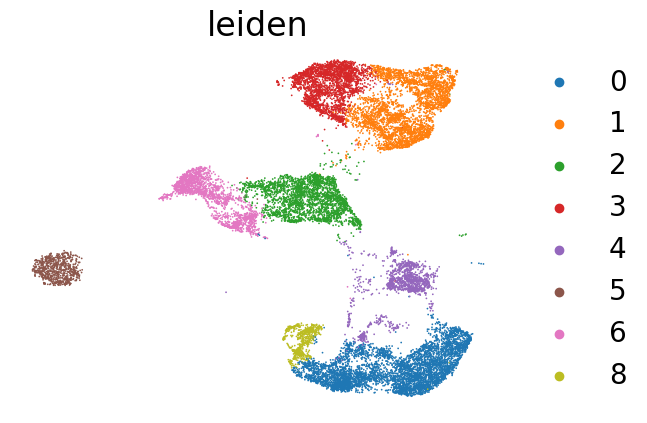

In [18]:
sc.pl.umap(
    adata,
    frameon=False,
    color=['leiden']
)

In [19]:
dict_clonetype_cell_clusters=adata_day6.obs.groupby('clonotype_id')['leiden'].apply(lambda x: list(set(x))).to_dict()
dict_clonetype_cell_count=adata_day6.obs['clonotype_id'].value_counts().to_dict()

# Create dictionaries for GC and PB counts
dict_gc_count = (
    adata_day6.obs[adata_day6.obs['leiden'].isin(['1', '3'])]  # Filter GC clusters
    .groupby('clonotype_id')
    .size()
    .to_dict()
)

dict_pb_count = (
    adata_day6.obs[adata_day6.obs['leiden'].isin(['0', '4', '8'])]  # Filter PB clusters
    .groupby('clonotype_id')
    .size()
    .to_dict()
)

dict_others_count = (
    adata_day6.obs[~adata_day6.obs['leiden'].isin(['1', '3', '0', '4', '8'])]  # Exclude specified clusters
    .groupby('clonotype_id')
    .size()
    .to_dict()
)

# Create the DataFrame
df_clonotype = pd.DataFrame(None)
df_clonotype['clonotype'] = list_clonotype_id_selected

# Add total cell count
df_clonotype['cell_count'] = df_clonotype['clonotype'].apply(lambda x: dict_clonetype_cell_count.get(x, 0))

# Add list of leiden clusters
df_clonotype['list_leiden'] = df_clonotype['clonotype'].apply(lambda x: dict_clonetype_cell_clusters.get(x, []))

# Add GC and PB classifications
df_clonotype['list_class'] = df_clonotype['list_leiden'].apply(
    lambda x: set(
        ['GC' if i in ['1', '3'] else 'PB' if i in ['0', '4', '8'] else 'others' for i in x]
    )
)

# Add GC and PB counts
df_clonotype['gc_count'] = df_clonotype['clonotype'].apply(lambda x: dict_gc_count.get(x, 0))
df_clonotype['pb_count'] = df_clonotype['clonotype'].apply(lambda x: dict_pb_count.get(x, 0))
df_clonotype['others_count'] = df_clonotype['clonotype'].apply(lambda x: dict_others_count.get(x, 0))

# Optional: Display the DataFrame
df_clonotype.head()

,clonotype,cell_count,list_leiden,list_class,gc_count,pb_count,others_count
0,clonotype2,7,"[0, 4]",{PB},0,7,0
1,clonotype8,6,"[0, 4]",{PB},0,6,0
2,clonotype17,5,[0],{PB},0,5,0
3,clonotype10,5,[0],{PB},0,5,0
4,clonotype20,5,"[0, 4]",{PB},0,5,0


In [20]:
# Merge `isotype` values from `adata_day6.obs` into `df_clonotype`
df_clonotype = df_clonotype.merge(
    adata_day6.obs[['clonotype_id', 'isotype']],
    how='left',  # Keep all rows from df_clonotype and merge where matches exist
    left_on='clonotype', 
    right_on='clonotype_id'
)

# Drop duplicate 'clonotype_id' column if necessary
df_clonotype = df_clonotype.drop(columns=['clonotype_id'])

In [21]:
df_clonotype.head(10)

,clonotype,cell_count,list_leiden,list_class,gc_count,pb_count,others_count,isotype
0,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1
1,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM
2,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM
3,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1
4,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1
5,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM
6,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1
7,clonotype8,6,"[0, 4]",{PB},0,6,0,IGKC
8,clonotype8,6,"[0, 4]",{PB},0,6,0,IGLC1
9,clonotype8,6,"[0, 4]",{PB},0,6,0,IGHM


In [22]:
df_clonotype['class']=df_clonotype['list_class'].apply(lambda x: "divergent" if (('PB' in x) and ('GC' in x) )
                                                       else "GC-skewed" if (('PB' not in x) and ('GC' in x))
                                                       else "PB-skewed" if (('PB'  in x) and ('GC' not in x))
                                                       else 'others'
                                                      )

In [23]:
df_clonotype['class'].value_counts()

class
PB-skewed    6625
GC-skewed    3637
others         58
divergent      34
Name: count, dtype: int64

In [24]:
total_clonotypes = len(df_clonotype['clonotype'].unique())
total_clonotypes

9495

In [25]:
total_cells = df_clonotype['cell_count'].sum()
total_cells

12504

In [26]:
total_pb_cells = df_clonotype['pb_count'].sum()

total_gc_cells = df_clonotype['gc_count'].sum()

total_others_cells = df_clonotype['others_count'].sum()

total_pb_cells, total_gc_cells, (total_pb_cells+total_gc_cells + total_others_cells)

(8695, 3751, 12504)

In [27]:
total_clones = df_clonotype[(df_clonotype['cell_count'] > 1)].shape[0]
total_clones

1556

In [28]:
total_clones_cells = df_clonotype[(df_clonotype['cell_count'] > 1)]['cell_count'].sum()
total_clones_cells

3706

In [29]:
pb_clones = df_clonotype[(df_clonotype['cell_count'] > 1) & (df_clonotype['class'] == 'PB-skewed') | (df_clonotype['class'] == 'divergent')].shape[0]
pb_clones

1479

In [30]:
pb_only_clones = df_clonotype[(df_clonotype['cell_count'] > 1) & (df_clonotype['class'] == 'PB-skewed')].shape[0]
pb_only_clones

1445

In [31]:
pb_clones_cells = df_clonotype[(df_clonotype['cell_count'] > 1)]['pb_count'].sum()
pb_clones_cells

3515

In [32]:
gc_clones = df_clonotype[(df_clonotype['cell_count'] > 1) & (df_clonotype['class'] == 'GC-skewed') | (df_clonotype['class'] == 'divergent')].shape[0]
gc_clones

111

In [33]:
gc_clones_cells = df_clonotype[(df_clonotype['cell_count'] > 1)]['gc_count'].sum()
gc_clones_cells

191

In [34]:
bifurcated_clones = df_clonotype[(df_clonotype['cell_count'] > 1) & (df_clonotype['class'] == 'divergent')].shape[0]
#bifurcated_clones = df_clonotype[(df_clonotype['class'] == 'divergent')].shape[0]
bifurcated_clones

34

In [35]:
bifurcated_clonotype_ids = df_clonotype[(df_clonotype['cell_count'] > 1) & (df_clonotype['class'] == 'divergent')]['clonotype'].tolist()

bifurcated_clonotype_ids[:5]

['clonotype137',
 'clonotype137',
 'clonotype137',
 'clonotype171',
 'clonotype171']

In [36]:
mean_pb_clone_size = df_clonotype[(df_clonotype['cell_count'] > 1) &
    df_clonotype['class'].isin(['PB-skewed', 'divergent'])
]['cell_count'].mean()

print(f"Mean cell count: {mean_pb_clone_size}")

Mean cell count: 2.3995943204868153


In [37]:
mean_gc_clone_size = df_clonotype[(df_clonotype['cell_count'] > 1) &
    df_clonotype['class'].isin(['GC-skewed', 'divergent'])
]['cell_count'].mean()

print(f"Mean cell count: {mean_gc_clone_size}")

Mean cell count: 2.081081081081081


In [38]:
pb_clones_cells + gc_clones_cells


3706

In [39]:
df_clonotype

,clonotype,cell_count,list_leiden,list_class,gc_count,pb_count,others_count,isotype,class
0,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
1,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
2,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
3,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
4,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
...,...,...,...,...,...,...,...,...,...
10349,clonotype585,1,[4],{PB},0,1,0,IGLC2,PB-skewed
10350,clonotype2324,1,[1],{GC},1,0,0,IGLC2,GC-skewed
10351,clonotype3650,1,[0],{PB},0,1,0,IGLC1,PB-skewed
10352,clonotype5729,1,[0],{PB},0,1,0,IGLC2,PB-skewed


In [40]:
# Filter for clonotypes with cell_count > 1 and at least one non-zero count in GC or PB
filtered_clonotypes = df_clonotype[
    (df_clonotype['cell_count'] > 1) & 
    ((df_clonotype['gc_count'] > 0) | (df_clonotype['pb_count'] > 0))
]

# Verify there are no rows with both gc_count and pb_count equal to zero
no_zeros = filtered_clonotypes[
    (filtered_clonotypes['gc_count'] == 0) & (filtered_clonotypes['pb_count'] == 0)
]

# Print results
if no_zeros.empty:
    print("Filtering successful: No rows where both GC and PB counts are zero.")
else:
    print("Warning: There are rows where both GC and PB counts are zero!")
    print(no_zeros)

# Output the number of filtered rows
print(f"Number of filtered clonotypes: {filtered_clonotypes.shape[0]}")


Filtering successful: No rows where both GC and PB counts are zero.
Number of filtered clonotypes: 1556


In [41]:
filtered_clonotypes

,clonotype,cell_count,list_leiden,list_class,gc_count,pb_count,others_count,isotype,class
0,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
1,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
2,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
3,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
4,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
...,...,...,...,...,...,...,...,...,...
1551,clonotype255,2,[0],{PB},0,2,0,IGLC1,PB-skewed
1552,clonotype808,2,"[0, 4]",{PB},0,2,0,IGKC,PB-skewed
1553,clonotype808,2,"[0, 4]",{PB},0,2,0,IGKC,PB-skewed
1554,clonotype361,2,[0],{PB},0,2,0,IGLC1,PB-skewed


In [42]:
# Create aligned PB and GC clone sizes
clone_sizes_pb = filtered_clonotypes['pb_count'].values  # PB clone sizes
clone_sizes_gc = filtered_clonotypes['gc_count'].values  # GC clone sizes
pb_clones_cells = filtered_clonotypes['pb_count'].sum()  # PB clone sizes
gc_clones_cells = filtered_clonotypes['gc_count'].sum()  # PB clone sizes

len(clone_sizes_pb), len(clone_sizes_gc), pb_clones_cells, gc_clones_cells

(1556, 1556, 3515, 191)

In [43]:
pb_clones = filtered_clonotypes[filtered_clonotypes['pb_count'] > 0].shape[0]
gc_clones = filtered_clonotypes[filtered_clonotypes['gc_count'] > 0].shape[0]
bifurcated_clones = filtered_clonotypes[(filtered_clonotypes['pb_count'] > 0) & (filtered_clonotypes['gc_count'] > 0)].shape[0]

pb_clones, gc_clones, bifurcated_clones

(1479, 111, 34)

In [44]:
pb_only_clone_count = filtered_clonotypes[(filtered_clonotypes['pb_count'] > 0) & (filtered_clonotypes['gc_count'] == 0)].shape[0]
gc_only_clone_count = filtered_clonotypes[(filtered_clonotypes['gc_count'] > 0) & (filtered_clonotypes['pb_count'] == 0)].shape[0]

pb_only_clone_count, gc_only_clone_count 

(1445, 77)

In [45]:
pb_only_clone_count + gc_only_clone_count + bifurcated_clones

1556

In [46]:
filtered_clonotypes.shape[0]

1556

# Clonal fate analysis

In [47]:
filtered_clonotypes

,clonotype,cell_count,list_leiden,list_class,gc_count,pb_count,others_count,isotype,class
0,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
1,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
2,clonotype2,7,"[0, 4]",{PB},0,7,0,IGHM,PB-skewed
3,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
4,clonotype2,7,"[0, 4]",{PB},0,7,0,IGLC1,PB-skewed
...,...,...,...,...,...,...,...,...,...
1551,clonotype255,2,[0],{PB},0,2,0,IGLC1,PB-skewed
1552,clonotype808,2,"[0, 4]",{PB},0,2,0,IGKC,PB-skewed
1553,clonotype808,2,"[0, 4]",{PB},0,2,0,IGKC,PB-skewed
1554,clonotype361,2,[0],{PB},0,2,0,IGLC1,PB-skewed


In [48]:
# Find indices where both PB and GC clone sizes are zero
zero_indices = np.where((clone_sizes_pb == 0) & (clone_sizes_gc == 0))[0]

# Count the number of such cases
num_zero_cases = len(zero_indices)
print(f"Number of clones where both PB and GC sizes are zero: {num_zero_cases}")

Number of clones where both PB and GC sizes are zero: 0


In [49]:
print(clone_sizes_pb.min(), clone_sizes_gc.min())
print(clone_sizes_pb.max(), clone_sizes_gc.max())

0 0
7 3


<Axes: ylabel='Count'>

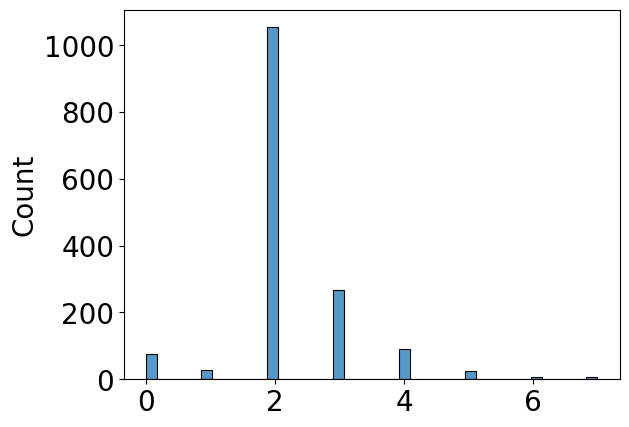

In [50]:
import seaborn as sns
sns.histplot(x=clone_sizes_pb)

<Axes: ylabel='Count'>

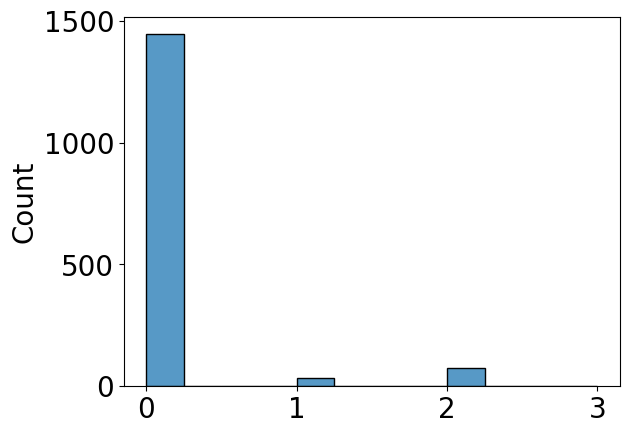

In [51]:
sns.histplot(x=clone_sizes_gc)

In [52]:
total_cells_sampled = filtered_clonotypes.shape[0]

# Example mean clone size (replace with actual mean from your data)
mean_pb_clone_size = np.mean(filtered_clonotypes['pb_count'].values)
# Generate Poisson-distributed clone sizes
poisson_clone_sizes_pb = np.random.poisson(mean_pb_clone_size, total_cells_sampled)

# Example mean clone size (replace with actual mean from your data)
mean_gc_clone_size = np.mean(filtered_clonotypes['gc_count'].values)
# Generate Poisson-distributed clone sizes
poisson_clone_sizes_gc = np.random.poisson(mean_gc_clone_size, total_cells_sampled)


In [53]:
mean_pb_clone_size

2.2589974293059125

In [54]:
poisson_clone_sizes_pb

array([1, 4, 3, ..., 2, 2, 3])

In [55]:
mean_gc_clone_size

0.12275064267352186

In [56]:
poisson_clone_sizes_gc

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
print(poisson_clone_sizes_pb.min(), poisson_clone_sizes_gc.min())
print(poisson_clone_sizes_pb.max(), poisson_clone_sizes_gc.max())

0 0
8 4


<Axes: ylabel='Count'>

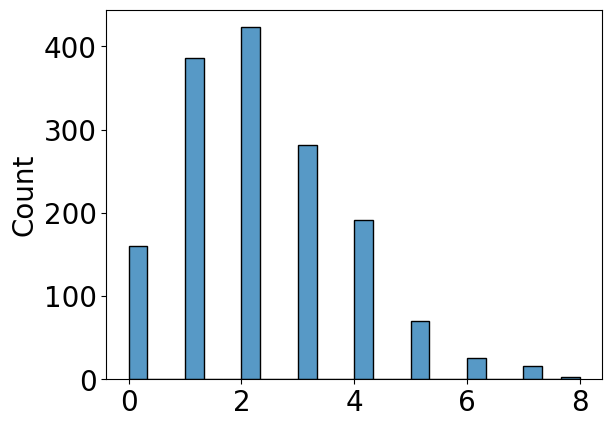

In [58]:
sns.histplot(x=poisson_clone_sizes_pb)

<Axes: ylabel='Count'>

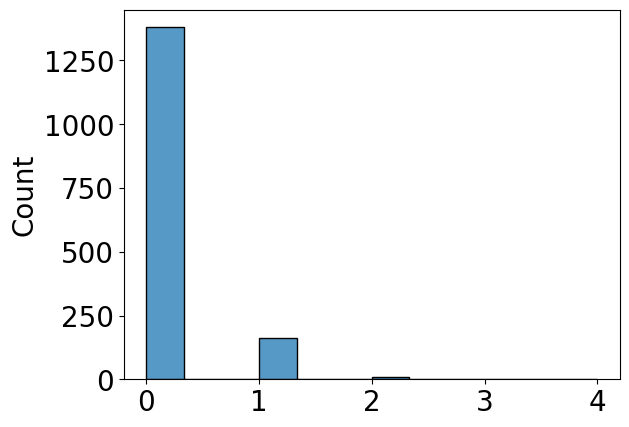

In [59]:
sns.histplot(x=poisson_clone_sizes_gc)

In [60]:
len(poisson_clone_sizes_gc),len(poisson_clone_sizes_pb)

(1556, 1556)

In [61]:
# Observed number of clones with only one fate (actual data)
N_actual_gc_only = gc_only_clone_count  # Replace with actual GC-only clone count
N_actual_pb_only = pb_only_clone_count  # Replace with actual PB-only clone count
N_actual_single_fate = N_actual_gc_only + N_actual_pb_only  # Total single-fate clones

# Total PB and GC cells sampled
n_pb = filtered_clonotypes['pb_count'].sum()
n_gc = filtered_clonotypes['gc_count'].sum()

# Total number of clones
total_clones = filtered_clonotypes.shape[0]  # Replace with the actual total number of unique clones

total_clones, n_pb, n_gc

(1556, 3515, 191)

In [62]:
# Monte Carlo Simulation for Expected GC-only, PB-only, and Mixed Clones
N_actual_gc_only = gc_only_clone_count
N_actual_pb_only = pb_only_clone_count
N_actual_single_fate = N_actual_gc_only + N_actual_pb_only

n_pb = filtered_clonotypes['pb_count'].sum()
n_gc = filtered_clonotypes['gc_count'].sum()

total_clones = filtered_clonotypes.shape[0]
num_permutations = 1000

gc_only_distribution = []
pb_only_distribution = []
mixed_distribution = []

for _ in range(num_permutations):
    np.random.shuffle(poisson_clone_sizes_pb)
    np.random.shuffle(poisson_clone_sizes_gc)

    pb_probs = poisson_clone_sizes_pb / poisson_clone_sizes_pb.sum()
    gc_probs = poisson_clone_sizes_gc / poisson_clone_sizes_gc.sum()

    sampled_pb = np.random.choice(len(poisson_clone_sizes_pb), n_pb, replace=True, p=pb_probs)
    sampled_gc = np.random.choice(len(poisson_clone_sizes_gc), n_gc, replace=True, p=gc_probs)

    pb_counts = pd.Series(sampled_pb).value_counts()
    gc_counts = pd.Series(sampled_gc).value_counts()

    pb_clones_all = set(pb_counts.index)
    gc_clones_all = set(gc_counts.index)

    # Mixed clones: any overlap, even if each has only 1 cell
    mixed_clones = pb_clones_all & gc_clones_all

    # Exclude mixed clones when defining "only" groups
    pb_only_raw = pb_clones_all - gc_clones_all
    gc_only_raw = gc_clones_all - pb_clones_all

    # Keep only those with ≥2 cells
    pb_only_clones = {clone for clone in pb_only_raw if pb_counts.get(clone, 0) >= 2}
    gc_only_clones = {clone for clone in gc_only_raw if gc_counts.get(clone, 0) >= 2}

    pb_only_distribution.append(len(pb_only_clones))
    gc_only_distribution.append(len(gc_only_clones))
    mixed_distribution.append(len(mixed_clones))

# Summary statistics
expected_gc_only = np.mean(gc_only_distribution)
expected_pb_only = np.mean(pb_only_distribution)
expected_mixed = np.mean(mixed_distribution)

ci_gc_lower, ci_gc_upper = np.percentile(gc_only_distribution, [5, 95])
ci_pb_lower, ci_pb_upper = np.percentile(pb_only_distribution, [5, 95])
ci_mixed_lower, ci_mixed_upper = np.percentile(mixed_distribution, [5, 95])

expected_gc_only, expected_pb_only, expected_mixed

(12.326, 805.409, 86.451)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'f', 'five', 'four', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 37, 38, 42, 50, 51, 68, 70, 71, 72, 73, 76, 79, 81, 82, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'MATH': 32 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G', 'O'

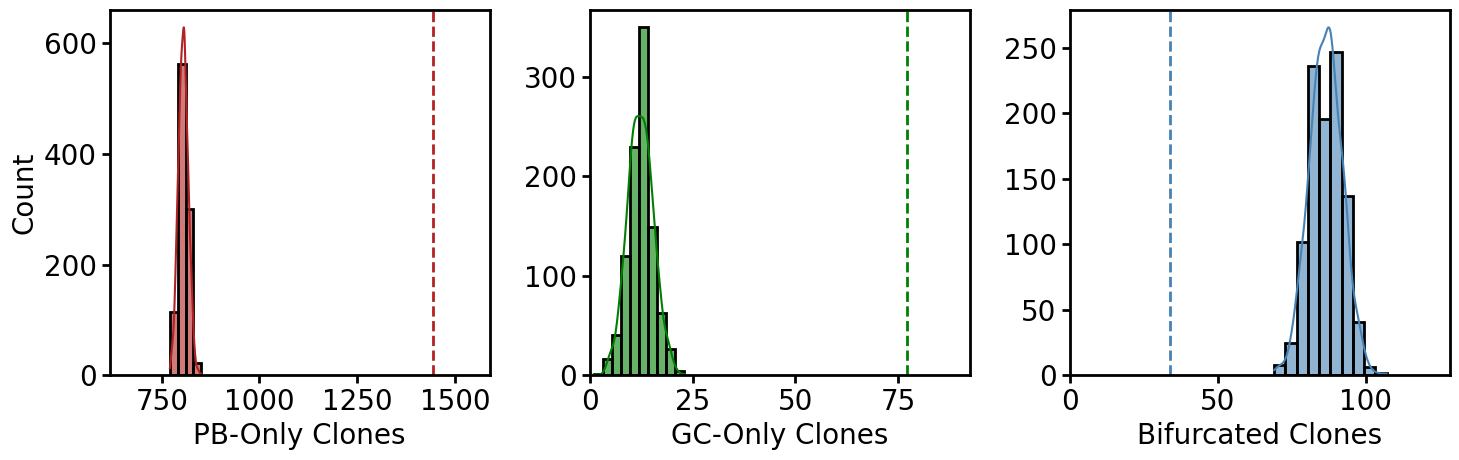

{'Expected PB-Only Clones': 805.409,
 '95% Confidence Interval (PB-Only)': (785.0, 826.0),
 'Expected GC-Only Clones': 12.326,
 '95% Confidence Interval (GC-Only)': (7.0, 17.0),
 'Expected Mixed Clones': 86.451,
 '95% Confidence Interval (Mixed)': (77.0, 95.0)}

In [63]:
# Generate visualization for GC-only, PB-only, and Mixed clones with x-axis starting at zero
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fontsizes = 20
linesizes=2
# Set common x-axis limits starting at zero
x_min = 0
x_max = max(max(gc_only_distribution), max(pb_only_distribution), max(mixed_distribution)) * 1.1

# PB-only clones distribution
sns.histplot(pb_only_distribution, bins=4, kde=True, color="firebrick", alpha=0.6, ax=axs[0], linewidth=linesizes)
axs[0].axvline(N_actual_pb_only, color='firebrick', linestyle='dashed', linewidth=2, label="Observed PB-Only Clones")
axs[0].set_xlabel("PB-Only Clones", fontsize=fontsizes)
axs[0].set_ylabel("Count", fontsize=fontsizes)
axs[0].set_xlim(min(pb_only_distribution)*0.8, N_actual_pb_only*1.1)
# Increase axes linewidth
axs[0].spines['top'].set_linewidth(2)
axs[0].spines['right'].set_linewidth(2)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)

# Increase tick width and length
axs[0].tick_params(width=2, length=6)

# GC-only clones distribution
sns.histplot(gc_only_distribution, bins=10, kde=True, color="green", alpha=0.6, ax=axs[1], linewidth=linesizes)
axs[1].axvline(N_actual_gc_only, color='green', linestyle='dashed', linewidth=2, label="Observed GC-Only Clones")
axs[1].set_xlabel("GC-Only Clones", fontsize=fontsizes)
axs[1].set_ylabel("", fontsize=fontsizes)
axs[1].set_xlim(x_min, N_actual_gc_only*1.2)

# Increase axes linewidth
axs[1].spines['top'].set_linewidth(2)
axs[1].spines['right'].set_linewidth(2)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)

# Increase tick width and length
axs[1].tick_params(width=2, length=6)

# Mixed clones distribution
sns.histplot(mixed_distribution, bins=10, kde=True, color="steelblue", alpha=0.6, ax=axs[2], linewidth=linesizes)
axs[2].axvline(bifurcated_clones, color='steelblue', linestyle='dashed', linewidth=2, label="Observed Mixed Clones")
axs[2].set_xlabel("Bifurcated Clones", fontsize=fontsizes)
axs[2].set_ylabel("", fontsize=fontsizes)
axs[2].set_xlim(x_min,  max(mixed_distribution)*1.2)

# Increase axes linewidth
axs[2].spines['top'].set_linewidth(2)
axs[2].spines['right'].set_linewidth(2)
axs[2].spines['bottom'].set_linewidth(2)
axs[2].spines['left'].set_linewidth(2)

# Increase tick width and length
axs[2].tick_params(width=2, length=6)

# Adjust layout
plt.tight_layout()

plt.savefig("/media/RAIDArray/Nick/projects/human_Bcell_GRN/donor1_upmc_scRNAseq/plots/monte_carlo_sims.pdf")

plt.show()

# Output the results
{
    "Expected PB-Only Clones": expected_pb_only,
    "95% Confidence Interval (PB-Only)": (ci_pb_lower, ci_pb_upper),
    "Expected GC-Only Clones": expected_gc_only,
    "95% Confidence Interval (GC-Only)": (ci_gc_lower, ci_gc_upper),
    "Expected Mixed Clones": expected_mixed,
    "95% Confidence Interval (Mixed)": (ci_mixed_lower, ci_mixed_upper)
}



In [64]:
# Compute Z-scores and p-values for each category

# GC-Only Clones
gc_z_score = (N_actual_gc_only - expected_gc_only) / np.std(gc_only_distribution)
gc_p_value = 2 * (1 - stats.norm.cdf(abs(gc_z_score)))

# PB-Only Clones
pb_z_score = (N_actual_pb_only - expected_pb_only) / np.std(pb_only_distribution)
pb_p_value = 2 * (1 - stats.norm.cdf(abs(pb_z_score)))

# Mixed (Bifurcated) Clones
mixed_z_score = (bifurcated_clones - expected_mixed) / np.std(mixed_distribution)
mixed_p_value = 2 * (1 - stats.norm.cdf(abs(mixed_z_score)))

# Output the statistical results
{
    "GC-Only Clones": {
        "Observed": N_actual_gc_only,
        "Expected": expected_gc_only,
        "Z-score": gc_z_score,
        "p-value": gc_p_value
    },
    "PB-Only Clones": {
        "Observed": N_actual_pb_only,
        "Expected": expected_pb_only,
        "Z-score": pb_z_score,
        "p-value": pb_p_value
    },
    "Mixed Clones": {
        "Observed": bifurcated_clones,
        "Expected": expected_mixed,
        "Z-score": mixed_z_score,
        "p-value": mixed_p_value
    }
}

{'GC-Only Clones': {'Observed': 77,
  'Expected': 12.326,
  'Z-score': 20.62599381220659,
  'p-value': 0.0},
 'PB-Only Clones': {'Observed': 1445,
  'Expected': 805.409,
  'Z-score': 51.35534349063631,
  'p-value': 0.0},
 'Mixed Clones': {'Observed': 34,
  'Expected': 86.451,
  'Z-score': -9.467998178217517,
  'p-value': 0.0}}

# distribution of clone sizes

In [65]:
# Make an explicit copy to avoid SettingWithCopyWarning
filtered_clonotypes = filtered_clonotypes.copy()

# Now safely assign the new column
filtered_clonotypes['list_class_frozen'] = filtered_clonotypes['list_class'].apply(frozenset)

# Get unique frozensets
unique_classes = filtered_clonotypes['list_class_frozen'].unique()
print(unique_classes)

[frozenset({'PB'}) frozenset({'PB', 'GC'}) frozenset({'GC'})]


In [66]:
filtered_df = filtered_clonotypes.copy()  # Make a copy if you're modifying the original

# Initialize with default value
filtered_df['group'] = 'Other'

# Assign groups based on conditions
filtered_df.loc[filtered_df['gc_count'] > 0, 'group'] = 'GC-containing clones'
filtered_df.loc[filtered_df['pb_count'] > 0, 'group'] = 'PB-containing clones'
filtered_df.loc[(filtered_df['pb_count'] > 0) & (filtered_df['gc_count'] > 0), 'group'] = 'bifurcated clones'

In [67]:
filtered_df['list_class_frozen'].unique()

array([frozenset({'PB'}), frozenset({'PB', 'GC'}), frozenset({'GC'})],
      dtype=object)

In [69]:
# Get cell count summary for each 'group' category
clone_count_summary = filtered_df['list_class_frozen'].value_counts().reset_index()
clone_count_summary.columns = ['list_class_frozen', 'clone_count']
clone_count_summary

,list_class_frozen,clone_count
0,(PB),1445
1,(GC),77
2,"(PB, GC)",34


In [71]:
# Get the sum of cell counts for each group
total_clone_count = clone_count_summary['clone_count'].sum()

# Display the total cell count
print(f"Total Cell Count: {total_clone_count}")

Total Cell Count: 1556


In [72]:
# Filter for clonotypes containing GC and PB
gc_clonotypes = filtered_df.loc[filtered_df['gc_count'] > 0].copy()
pb_clonotypes = filtered_df.loc[filtered_df['pb_count'] > 0].copy()

# Add a category column for labeling
gc_clonotypes['Category'] = 'GC Clonotypes'
pb_clonotypes['Category'] = 'PB Clonotypes'

# Combine the data
violin_data = pd.concat([pb_clonotypes, gc_clonotypes])

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 25 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G', 'P', 'S', 'e', 'five', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'z']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 21, 22, 23, 24, 25, 26, 37, 38, 42, 51, 54, 72, 76, 79, 81, 82, 83, 86, 87, 92, 93]
INFO:fontTools.subset:Closed glyph list over 'MATH': 25 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G', 'P', 'S', 'e', 'five', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 

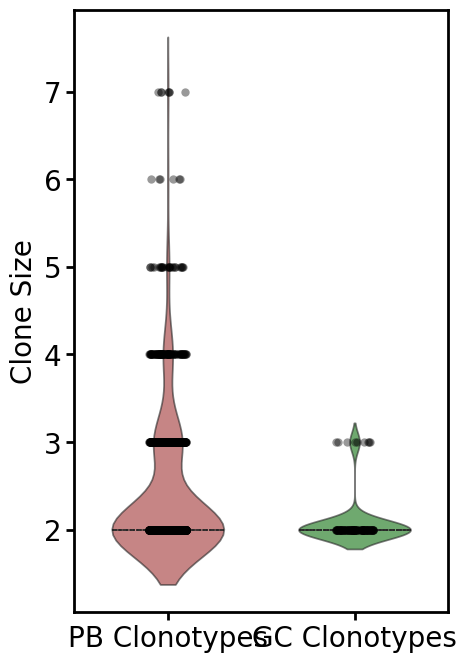

In [73]:
# Create the plot
plt.figure(figsize=(5, 7))

# Define custom colors for the violins
custom_palette = {
    'GC Clonotypes': 'green',
    'PB Clonotypes': 'firebrick',
}


# Violin plot with reduced width
sns.violinplot(
    data=violin_data,
    hue='Category',
    palette=custom_palette,
    alpha = 0.6,
    x='Category',
    y='cell_count',
    density_norm='width',  # Reduce the width to match the data distribution
    inner='quartile',  # Show quartiles
    bw_method=0.4,  # Bandwidth to control smoothing of the violin
    width=0.6  # Adjust overall width of the violins
)

# Overlay a dot plot
sns.stripplot(
    data=violin_data,
    x='Category',
    y='cell_count',
    color='black',  # Color for the dots
    alpha=0.4,  # Adjust transparency
    jitter=0.1,  # Add jitter to avoid overlapping dots
    size=6  # Size of the dots
)

# Customize the plot
plt.xlabel('', fontsize=12)
plt.ylabel('Clone Size', fontsize=20)
#plt.title('Violin Plot of Cell Count with Dots by Clonotype Group', fontsize=14)
plt.tight_layout()

# Increase axes linewidth
ax = plt.gca()  # Get current axis

# Set linewidth for all spines
for axis in ['top', 'right', 'bottom', 'left']:
    ax.spines[axis].set_linewidth(2)  # Adjust linewidth as needed

# Increase tick width and length
ax.tick_params(width=2, length=6)

plt.savefig("/media/RAIDArray/Nick/projects/human_Bcell_GRN/donor1_upmc_scRNAseq/plots/clone_size_violin.pdf")
# Show the plot
plt.show()


# Isotype analysis

In [74]:
filtered_clonotype_igh = filtered_clonotypes[filtered_clonotypes['isotype'].str.contains('IGH', na=False, case=False)]

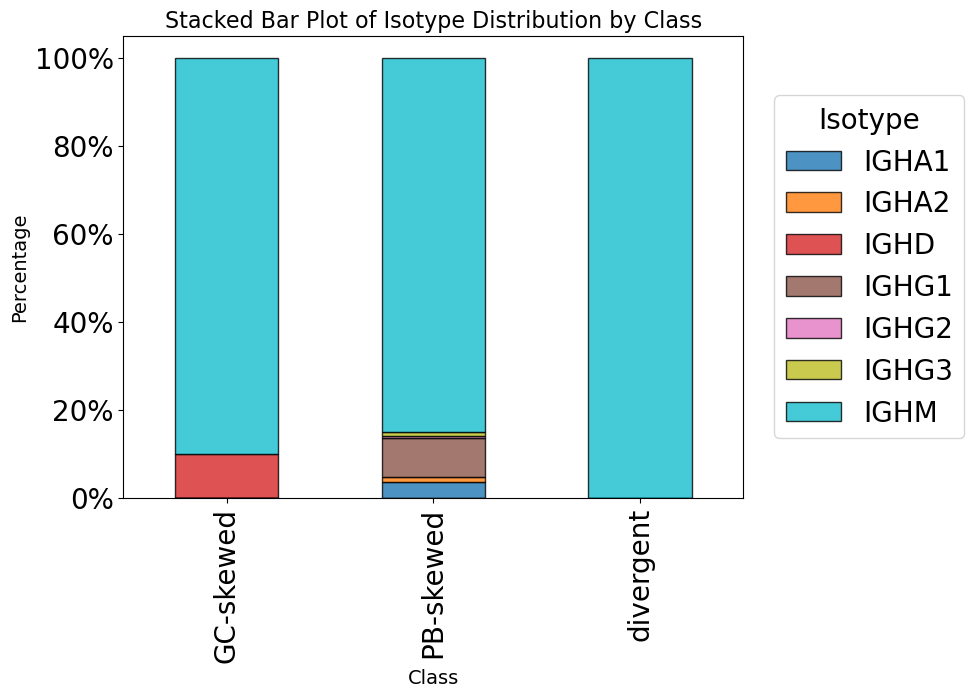

In [75]:
# Pivot the data to get 'isotype' as separate columns
df_pivot = filtered_clonotype_igh.groupby(['class', 'isotype']).size().unstack(fill_value=0)

# Normalize to proportions (percent stacked)
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
df_pivot.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', alpha=0.8, ax=ax)

# Labels and title
plt.xlabel("Class", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.title("Stacked Bar Plot of Isotype Distribution by Class", fontsize=16)
plt.legend(title="Isotype", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Convert y-axis to percentage format
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))

# Show the plot
plt.show()

# visualization of representative clones

In [76]:
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=300, fontsize=15)
background_size = 6
clone_size = 250

In [77]:
# Randomly sample one bifurcated clonotype_id
# bifurcated_clonotype_ids = adata.obs.loc[adata.obs['clonotype_class'] == 'bifurcated', 'clonotype_id'].unique()
# bifurcated_example_clonotype = np.random.choice(bifurcated_clonotype_ids)

# pb_only_clonotype_ids = adata.obs.loc[adata.obs['clonotype_class'] == 'pb-skewed', 'clonotype_id'].unique()
# pb_only_example_clonotype = np.random.choice(pb_only_clonotype_ids)

# gc_only_clonotype_ids = adata.obs.loc[adata.obs['clonotype_class'] == 'gc-skewed', 'clonotype_id'].unique()
# gc_only_example_clonotype = np.random.choice(gc_only_clonotype_ids)

# good representative clones
bifurcated_example_clonotype = "clonotype1047"
pb_only_example_clonotype = "clonotype946"
gc_only_example_clonotype = "clonotype467" 

/media/RAIDArray/Nick/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/media/RAIDArray/Nick/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/media/RAIDArray/Nick/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTo

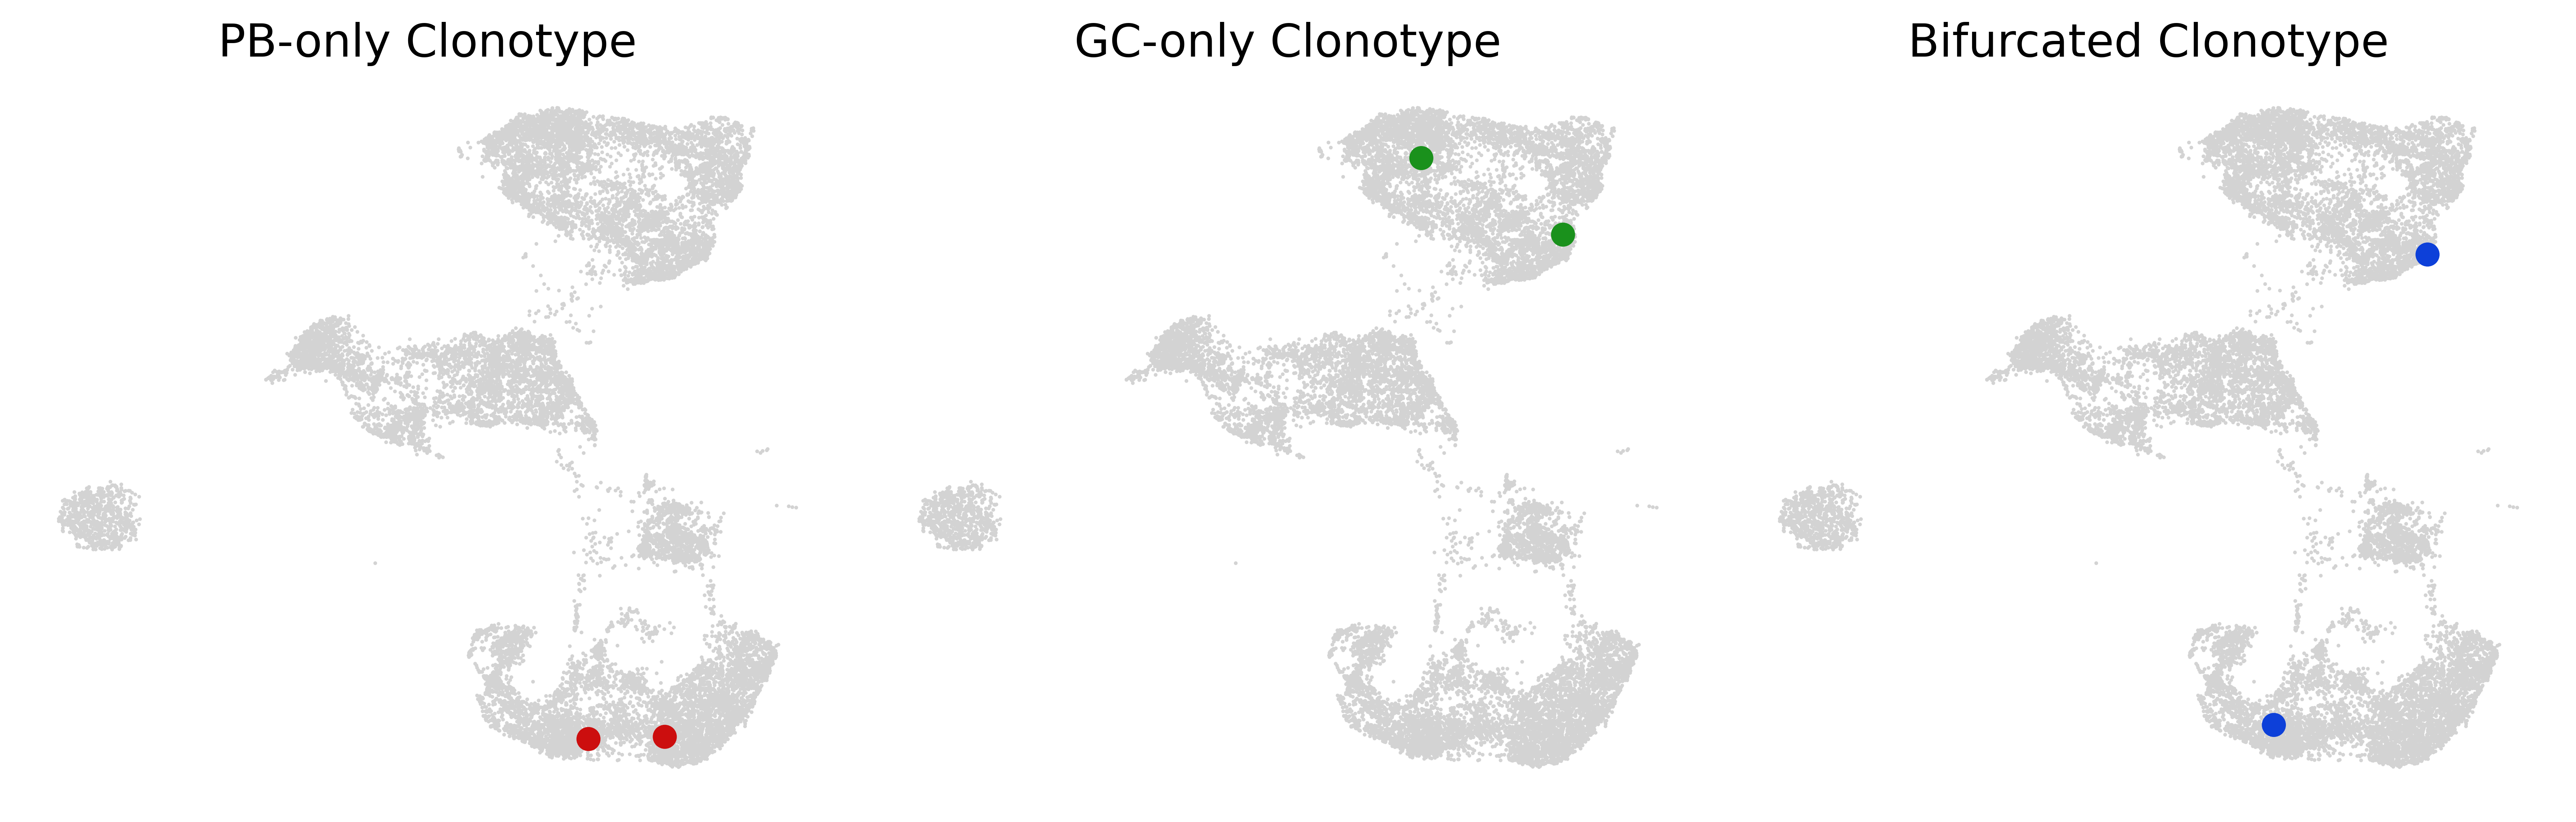

In [78]:

# Define colors
background_color = "lightgray"
pb_color = "#cc0e0e"
gc_color = "#1a911c"
bifurcated_color = "#0d40d9"

# Create a Matplotlib figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot PB-only Clonotype
sc.pl.umap(
    adata, 
    color=None,  # Background cells
    frameon=False,
    size=background_size, 
    show=False, 
    ax=axs[0]
)
sc.pl.umap(
    adata[adata.obs['clonotype_id'] == pb_only_example_clonotype],
    color='clonotype_id',  # Color by clonotype
    frameon=False,
    ax=axs[0],
    size=clone_size,
    palette={pb_only_example_clonotype: pb_color},  # Apply firebrick color
    legend_loc=None,
    show=False
)
axs[0].set_title("PB-only Clonotype")

# Plot GC-only Clonotype
sc.pl.umap(
    adata, 
    color=None,  # Background cells
    frameon=False,
    size=background_size, 
    show=False, 
    ax=axs[1]
)
sc.pl.umap(
    adata[adata.obs['clonotype_id'] == gc_only_example_clonotype],
    color='clonotype_id',  # Color by clonotype
    frameon=False,
    ax=axs[1],
    size=clone_size,
    palette={gc_only_example_clonotype: gc_color},  # Apply green color
    legend_loc=None,
    show=False
)
axs[1].set_title("GC-only Clonotype")

# Plot Bifurcated Clonotype
sc.pl.umap(
    adata, 
    color=None,  # Background cells
    frameon=False,
    size=background_size, 
    show=False, 
    ax=axs[2]
)
sc.pl.umap(
    adata[adata.obs['clonotype_id'] == bifurcated_example_clonotype],
    color='clonotype_id',  # Color by clonotype
    frameon=False,
    ax=axs[2],
    size=clone_size,
    palette={bifurcated_example_clonotype: bifurcated_color},  # Apply steelblue color
    legend_loc=None,
    show=False
)
axs[2].set_title("Bifurcated Clonotype")

# Adjust layout: Increase horizontal spacing
plt.subplots_adjust(wspace=0.4)  # Increase spacing between subplots

# Save the figure as a PDF
plt.tight_layout()
plt.savefig("/media/RAIDArray/Nick/projects/human_Bcell_GRN/donor1_upmc_scRNAseq/plots/clonotype_umap.pdf", dpi=300)
plt.show()